In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [150]:
# Function to preprocess data before applying strategy
def preprocess(data):
    if 'label' in data.columns:
        temp = data[['Date', 'Open', 'Close', 'label']].copy()
    else:
        temp = data[['Date', 'Open', 'Close']].copy()
    temp['Norm_return'] = temp['Close'] / temp.iloc[0]['Close']
    temp['Allocation'] = temp['Norm_return'] * 1
    temp['Position'] = temp['Allocation'] * 1000 #Assume portfolio size is 10K
    temp['Daily_return'] = temp['Position'].pct_change(1)
    return temp

# Strategy 1: buy today and sell tomorrow immediately if price increases
def strategy1(data):
    new_rows = list()
    for i, row in data.iterrows():
        if(row['Predicted Values'] == 1):
            new_rows.append(row['Daily Return'])
        else:
            new_rows.append(None)
    new_rows_np = np.array(new_rows, dtype=np.float)
    return new_rows, new_rows_np

# Strategy 2: if tomorrow is increasing, buy today and keep stock until price decreases
def strategy2(data):
    buy = False
    new_rows = list()
    for i, row in data.iterrows():
        if(row['Predicted Values'] == 1 and buy == False):
            buy = True
            new_rows.append(None)
        elif(buy == True and row['Predicted Values'] == -1):
            buy = False
            new_rows.append(None)
        elif(buy == True):
            new_rows.append(row['Daily Return'])
        else:
            new_rows.append(None)
    new_rows_np = np.array(new_rows, dtype=np.float)
    return new_rows, new_rows_np

# Trend Strategy
def trendStrategy(data):
    buy = False
    new_rows = list()
    for i, row in data.iterrows():
        if(row['FGS'] != 0 and buy == False):
            buy = True
            new_rows.append(None)
        elif(buy == True and row['FGS'] == 0):
            buy = False
            new_rows.append(None)
        elif(buy == True):
            new_rows.append(row['Daily_return'])
        else:
            new_rows.append(None)
    new_rows_np = np.array(new_rows, dtype=np.float)
    return new_rows, new_rows_np

# Function that returns sharpe ratio
def getSharpeRatio(np_data):
    # Note: Run strategies above first to get np data
    # Assume Risk free ratio is 0
    sharpeRatio = (np.nanmean(np_data) - 0)/np.nanstd(np_data)
    return sharpeRatio


In [151]:
# Read main dataset for NQ
nq = pd.read_csv('@NQ_Daily.txt', sep=',')

In [166]:
# 1st period: 01/10/2007 - 11/03/2008 -> Overall decreasing price trend
nq_1 = nq[1856:2307]
nq_1 = preprocess(nq_1)
nq_1_temp = nq[1857:2308]
nq_1_temp = preprocess(nq_1_temp)
nq_1_test = [nq_1, nq['FGS'][1856:2307]]
nq_1_test = pd.concat(nq_1_test, axis=1)

In [167]:
# Show last 5 rows
nq_1_temp.tail()

,Date,Open,Close,Norm_return,Allocation,Position,Daily_return
2303,10/20/2008,1205.75,1251.75,0.690525,0.690525,690.525445,0.040740
2304,10/21/2008,1256.00,1184.25,0.653289,0.653289,653.289201,-0.053925
2305,10/22/2008,1181.75,1139.75,0.628741,0.628741,628.740863,-0.037577
2306,10/23/2008,1137.75,1145.25,0.631775,0.631775,631.774928,0.004826
2307,10/24/2008,1141.50,1083.25,0.597573,0.597573,597.572749,-0.054137


# Sharpe Ratio calculations for Period 1
## 1. Buy and Hold

In [170]:
buyandholdRows = list()
for i, row in nq_1.iterrows():
        buyandholdRows.append(row['Daily_return'])

In [171]:
buyandholdRows_np = np.array(buyandholdRows, dtype=np.float)
buyandhold_sharpe = np.nanmean(buyandholdRows_np)/np.nanstd(buyandholdRows_np)
buyandhold_sharpe

-0.043921177907573515

## 2. Trend Strategy

In [172]:
trendRows, trendRows_np = trendStrategy(nq_1_test)

In [222]:
print("Sharpe Ratio for Trend Strategy is: ", getSharpeRatio(trendRows_np))

Sharpe Ratio for Trend Strategy is:  -0.0003897079766404047


## 3. Bi-Directional LSTM
### Preparation

In [174]:
lstm_prediction = pd.read_csv('data/bi_lstm_first_half.csv')
lstm_prediction = lstm_prediction[:-5]
lstm_prediction.tail()

,Date,True Closing Values,Predicted Closing Values,True Values,Predicted Values
446,10/20/2008,1251.75,1247.541378,Up,Up
447,10/21/2008,1184.25,1297.587478,Down,Up
448,10/22/2008,1139.75,1357.166026,Down,Up
449,10/23/2008,1145.25,1264.819095,Up,Up
450,10/24/2008,1083.25,1066.653232,Down,Down


In [175]:
##Change to 1, 0, -1 (Up, Down, No change)
lstm_prediction['True Values'] = lstm_prediction['True Values'].map({'No Change': 0, 'Down': -1, 'Up': 1})
lstm_prediction['Predicted Values'] = lstm_prediction['Predicted Values'].map({'No Change': 0, 'Down': -1, 'Up': 1})

In [176]:
nq_1_temp = preprocess(nq_1_temp)
lstm_prediction = lstm_prediction.set_index(nq_1_temp.index)
lstm_prediction['Date'] = nq_1_temp.iloc[:,0].values
lstm_prediction.head()

,Date,True Closing Values,Predicted Closing Values,True Values,Predicted Values
1857,01/19/2007,1812.75,1789.474657,NaN,NaN
1858,01/22/2007,1798.50,1782.533149,-1.0,-1.0
1859,01/23/2007,1793.25,1777.010738,0.0,-1.0
1860,01/24/2007,1821.50,1775.143335,1.0,-1.0
1861,01/25/2007,1797.50,1772.227663,-1.0,-1.0


In [177]:
lstm_prediction["Daily Return"] = nq_1_temp['Daily_return']
lstm_prediction.head()

,Date,True Closing Values,Predicted Closing Values,True Values,Predicted Values,Daily Return
1857,01/19/2007,1812.75,1789.474657,NaN,NaN,NaN
1858,01/22/2007,1798.50,1782.533149,-1.0,-1.0,-0.007861
1859,01/23/2007,1793.25,1777.010738,0.0,-1.0,-0.002919
1860,01/24/2007,1821.50,1775.143335,1.0,-1.0,0.015754
1861,01/25/2007,1797.50,1772.227663,-1.0,-1.0,-0.013176


### Bi-directional LSTM: Model Strategy 1

In [178]:
lstm_rows_1, lstm_np_1 = strategy1(lstm_prediction)

In [179]:
print("Sharpe Ratio for Bi-Directional LSTM using strategy 1 is: ", getSharpeRatio(lstm_np_1))

Sharpe Ratio for Bi-Directional LSTM using strategy 1 is:  0.03164753160747525


### Bi-directional LSTM: Model Strategy 2

In [180]:
lstm_rows_2, lstm_np_2 = strategy2(lstm_prediction)

In [181]:
print("Sharpe Ratio for Bi-Directional LSTM using strategy 2 is: ", getSharpeRatio(lstm_np_2))

Sharpe Ratio for Bi-Directional LSTM using strategy 2 is:  0.017997062066500414


## 4. CNN

In [182]:
cnn_prediction = pd.read_csv('data/cnn_first_half.csv')
cnn_prediction = cnn_prediction[4:-1]
cnn_prediction.head()

,Date,True Closing Values,Predicted Closing Values,True Values,Predicted Values
4,01/19/2007,1812.75,1810.676401,No Change,No Change
5,01/22/2007,1798.50,1842.040795,Down,Up
6,01/23/2007,1793.25,1766.560795,No Change,Down
7,01/24/2007,1821.50,1828.744729,Up,Up
8,01/25/2007,1797.50,1864.814104,Down,Up


In [183]:
##Change to 1, 0, -1 (Up, Down, No change)
cnn_prediction['True Values'] = cnn_prediction['True Values'].map({'No Change': 0, 'Down': -1, 'Up': 1})
cnn_prediction['Predicted Values'] = cnn_prediction['Predicted Values'].map({'No Change': 0, 'Down': -1, 'Up': 1})

In [184]:
nq_1_temp = preprocess(nq_1_temp)
cnn_prediction = cnn_prediction.set_index(nq_1_temp.index)
cnn_prediction['Date'] = nq_1_temp.iloc[:,0].values
cnn_prediction.tail()

,Date,True Closing Values,Predicted Closing Values,True Values,Predicted Values
2303,10/20/2008,1251.75,1034.177940,1,-1
2304,10/21/2008,1184.25,1203.966007,-1,-1
2305,10/22/2008,1139.75,1194.189285,-1,1
2306,10/23/2008,1145.25,1116.396842,1,-1
2307,10/24/2008,1083.25,1103.461963,-1,-1


In [185]:
cnn_prediction["Daily Return"] = nq_1_temp['Daily_return']
cnn_prediction.head()

,Date,True Closing Values,Predicted Closing Values,True Values,Predicted Values,Daily Return
1857,01/19/2007,1812.75,1810.676401,0,0,NaN
1858,01/22/2007,1798.50,1842.040795,-1,1,-0.007861
1859,01/23/2007,1793.25,1766.560795,0,-1,-0.002919
1860,01/24/2007,1821.50,1828.744729,1,1,0.015754
1861,01/25/2007,1797.50,1864.814104,-1,1,-0.013176


### CNN: Model Strategy 1

In [186]:
cnn_rows_1, cnn_np_1 = strategy1(cnn_prediction)
print("Sharpe Ratio for cnn using strategy 1 is: ", getSharpeRatio(cnn_np_1))

Sharpe Ratio for cnn using strategy 1 is:  -0.0049970429735901175


### CNN: Model Strategy 2

In [187]:
cnn_rows_2, cnn_np_2 = strategy2(cnn_prediction)
print("Sharpe Ratio for cnn using strategy 2 is: ", getSharpeRatio(cnn_np_2))

Sharpe Ratio for cnn using strategy 2 is:  -0.0026302948105813642


## 5. CSC

In [188]:
csc_prediction = pd.read_csv('data/csc_first_half.csv')
csc_prediction = csc_prediction[4:-6]
csc_prediction.tail()

,Date,True Closing Values,Predicted Closing Values,True Values,Predicted Values
450,10/20/2008,1251.75,1202.500016,Up,No Change
451,10/21/2008,1184.25,1279.987622,Down,Up
452,10/22/2008,1139.75,1256.643159,Down,Up
453,10/23/2008,1145.25,1167.666305,Up,Up
454,10/24/2008,1083.25,1135.300049,Down,Down


In [189]:
##Change to 1, 0, -1 (Up, Down, No change)
csc_prediction['True Values'] = csc_prediction['True Values'].map({'No Change': 0, 'Down': -1, 'Up': 1})
csc_prediction['Predicted Values'] = csc_prediction['Predicted Values'].map({'No Change': 0, 'Down': -1, 'Up': 1})

In [190]:
nq_1_temp = preprocess(nq_1_temp)
csc_prediction = csc_prediction.set_index(nq_1_temp.index)
csc_prediction['Date'] = nq_1_temp.iloc[:,0].values
csc_prediction.head()

,Date,True Closing Values,Predicted Closing Values,True Values,Predicted Values
1857,01/19/2007,1812.75,1815.415907,0,0
1858,01/22/2007,1798.50,1813.971924,-1,0
1859,01/23/2007,1793.25,1787.459552,0,-1
1860,01/24/2007,1821.50,1789.654367,1,0
1861,01/25/2007,1797.50,1835.419182,-1,1


In [191]:
csc_prediction["Daily Return"] = nq_1_temp['Daily_return']
csc_prediction.head()

,Date,True Closing Values,Predicted Closing Values,True Values,Predicted Values,Daily Return
1857,01/19/2007,1812.75,1815.415907,0,0,NaN
1858,01/22/2007,1798.50,1813.971924,-1,0,-0.007861
1859,01/23/2007,1793.25,1787.459552,0,-1,-0.002919
1860,01/24/2007,1821.50,1789.654367,1,0,0.015754
1861,01/25/2007,1797.50,1835.419182,-1,1,-0.013176


### CSC: Model Strategy 1

In [192]:
csc_rows_1, csc_np_1 = strategy1(csc_prediction)
print("Sharpe Ratio for csc using strategy 1 is: ", getSharpeRatio(csc_np_1))

Sharpe Ratio for csc using strategy 1 is:  0.02315438626827678


### CSC: Model Strategy 2

In [193]:
csc_rows_2, csc_np_2 = strategy2(csc_prediction)
print("Sharpe Ratio for csc using strategy 2 is: ", getSharpeRatio(csc_np_2))

Sharpe Ratio for csc using strategy 2 is:  0.01799904747732428


## 6. Bi-Directional LSTM Autoencoders

In [194]:
biauto_prediction = pd.read_csv('data/bi_lstm_autoencoders_first_half.csv')
biauto_prediction = biauto_prediction[:-6]
biauto_prediction.tail()

,Date,True Closing Values,Predicted Closing Values,True Values,Predicted Values
446,10/20/2008,1251.75,1288.109051,Up,Up
447,10/21/2008,1184.25,1240.541355,Down,Down
448,10/22/2008,1139.75,1202.453930,Down,Up
449,10/23/2008,1145.25,1141.830454,Up,No Change
450,10/24/2008,1083.25,1100.926076,Down,Down


In [195]:
##Change to 1, 0, -1 (Up, Down, No change)
biauto_prediction['True Values'] = biauto_prediction['True Values'].map({'No Change': 0, 'Down': -1, 'Up': 1})
biauto_prediction['Predicted Values'] = biauto_prediction['Predicted Values'].map({'No Change': 0, 'Down': -1, 'Up': 1})

In [196]:
nq_1_temp = preprocess(nq_1_temp)
biauto_prediction = biauto_prediction.set_index(nq_1_temp.index)
biauto_prediction['Date'] = nq_1_temp.iloc[:,0].values
biauto_prediction.head()

,Date,True Closing Values,Predicted Closing Values,True Values,Predicted Values
1857,01/19/2007,1812.75,1841.283574,NaN,NaN
1858,01/22/2007,1798.50,1828.092737,-1.0,1.0
1859,01/23/2007,1793.25,1812.622005,0.0,1.0
1860,01/24/2007,1821.50,1797.779918,1.0,0.0
1861,01/25/2007,1797.50,1785.128527,-1.0,-1.0


In [197]:
biauto_prediction["Daily Return"] = nq_1_temp['Daily_return']
biauto_prediction.head()

,Date,True Closing Values,Predicted Closing Values,True Values,Predicted Values,Daily Return
1857,01/19/2007,1812.75,1841.283574,NaN,NaN,NaN
1858,01/22/2007,1798.50,1828.092737,-1.0,1.0,-0.007861
1859,01/23/2007,1793.25,1812.622005,0.0,1.0,-0.002919
1860,01/24/2007,1821.50,1797.779918,1.0,0.0,0.015754
1861,01/25/2007,1797.50,1785.128527,-1.0,-1.0,-0.013176


### Strategy 1

In [198]:
biauto_rows_1, biauto_np_1 = strategy1(biauto_prediction)
print("Sharpe Ratio for bidirectional autoencoder using strategy 1 is: ", getSharpeRatio(biauto_np_1))

Sharpe Ratio for bidirectional autoencoder using strategy 1 is:  0.10401781104271189


### Strategy 2

In [199]:
biauto_rows_2, biauto_np_2 = strategy2(biauto_prediction)
print("Sharpe Ratio for bidirectional autoencoder using strategy 2 is: ", getSharpeRatio(biauto_np_2))

Sharpe Ratio for bidirectional autoencoder using strategy 2 is:  0.0905407289545464


## 7. WaveNet

In [200]:
wavenet_prediction = pd.read_csv('data/wavenet_first_half.csv')
wavenet_prediction = wavenet_prediction.rename(index=str, columns={"Next_Day_Prediction": "Predicted Values", "Next_Day_Original": "True Values"})
wavenet_prediction = wavenet_prediction[1:-3]

In [201]:
##Change to 1, 0, -1 (Up, Down, No change)
wavenet_prediction['True Values'] = wavenet_prediction['True Values'].map({'No Change': 0, 'Down': -1, 'Up': 1})
wavenet_prediction['Predicted Values'] = wavenet_prediction['Predicted Values'].map({'No Change': 0, 'Down': -1, 'Up': 1})

In [202]:
wavenet_prediction = wavenet_prediction.set_index(nq_1_temp.index)
wavenet_prediction['Date'] = nq_1_temp.iloc[:,0].values
wavenet_prediction.head()

,Date,Predicted Values,True Values
1857,01/19/2007,1,-1
1858,01/22/2007,-1,0
1859,01/23/2007,1,1
1860,01/24/2007,1,-1
1861,01/25/2007,1,-1


In [203]:
wavenet_prediction['Daily Return'] = nq_1_temp['Daily_return']
wavenet_prediction.head()

,Date,Predicted Values,True Values,Daily Return
1857,01/19/2007,1,-1,NaN
1858,01/22/2007,-1,0,-0.007861
1859,01/23/2007,1,1,-0.002919
1860,01/24/2007,1,-1,0.015754
1861,01/25/2007,1,-1,-0.013176


### Strategy 1

In [204]:
wavenet_rows_1, wavenet_np_1 = strategy1(wavenet_prediction)

In [205]:
print("Sharpe Ratio for WaveNet using strategy 1 is: ", getSharpeRatio(wavenet_np_1))

Sharpe Ratio for WaveNet using strategy 1 is:  0.12990165159479236


### Strategy 2

In [206]:
wavenet_rows_2, wavenet_np_2 = strategy2(wavenet_prediction)

In [207]:
print("Sharpe Ratio for WaveNet using strategy 2 is: ", getSharpeRatio(wavenet_np_2))

Sharpe Ratio for WaveNet using strategy 2 is:  0.08743029724341


# Stock Market Simulations - Cumulative Returns Plot

In [234]:
# Data preprocessing
strategies = nq_1_temp
strategies['bi_lstm_strategy1'] = lstm_rows_1
strategies['bi_lstm_strategy2'] = lstm_rows_2
strategies['bi_lstm_auto_strategy1'] = biauto_rows_1
strategies['bi_lstm_auto_strategy2'] = biauto_rows_2
strategies['tcn_strategy1'] = wavenet_rows_1
strategies['tcn_strategy2'] = wavenet_rows_2
strategies['cnn_strategy1'] = cnn_rows_1
strategies['cnn_strategy2'] = cnn_rows_2
strategies['csc_strategy1'] = csc_rows_1
strategies['csc_strategy2'] = csc_rows_2
strategies['trendStrategy'] = trendRows

In [235]:
# Print top 5 rows
strategies.head()

,Date,Open,Close,Norm_return,Allocation,Position,Daily_return,bi_lstm_strategy1,bi_lstm_strategy2,bi_lstm_auto_strategy1,bi_lstm_auto_strategy2,wavenet_strategy1,wavenet_strategy2,cnn_strategy1,cnn_strategy2,csc_strategy1,csc_strategy2,trendStrategy,tcn_strategy1,tcn_strategy2
1857,01/19/2007,1811.75,1812.75,1.000000,1.000000,1000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1858,01/22/2007,1813.25,1798.50,0.992139,0.992139,992.139015,-0.007861,NaN,NaN,-0.007861,NaN,NaN,NaN,-0.007861,NaN,NaN,NaN,0.000276,NaN,NaN
1859,01/23/2007,1798.75,1793.25,0.989243,0.989243,989.242863,-0.002919,NaN,NaN,-0.002919,-0.002919,-0.002919,NaN,NaN,NaN,NaN,NaN,-0.007861,-0.002919,NaN
1860,01/24/2007,1792.75,1821.50,1.004827,1.004827,1004.826920,0.015754,NaN,NaN,NaN,0.015754,0.015754,0.015754,0.015754,NaN,NaN,NaN,-0.002919,0.015754,0.015754
1861,01/25/2007,1825.75,1797.50,0.991587,0.991587,991.587367,-0.013176,NaN,NaN,NaN,NaN,-0.013176,-0.013176,-0.013176,-0.013176,-0.013176,NaN,0.015754,-0.013176,-0.013176


In [236]:
strategies = strategies.rename(index=str, columns={"Daily_return": "buyhold"})
strategies = strategies.drop(columns=['Open', 'Norm_return', 'Allocation', 'Position', 'Close'])
strategies.head()

,Date,buyhold,bi_lstm_strategy1,bi_lstm_strategy2,bi_lstm_auto_strategy1,bi_lstm_auto_strategy2,wavenet_strategy1,wavenet_strategy2,cnn_strategy1,cnn_strategy2,csc_strategy1,csc_strategy2,trendStrategy,tcn_strategy1,tcn_strategy2
1857,01/19/2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1858,01/22/2007,-0.007861,NaN,NaN,-0.007861,NaN,NaN,NaN,-0.007861,NaN,NaN,NaN,0.000276,NaN,NaN
1859,01/23/2007,-0.002919,NaN,NaN,-0.002919,-0.002919,-0.002919,NaN,NaN,NaN,NaN,NaN,-0.007861,-0.002919,NaN
1860,01/24/2007,0.015754,NaN,NaN,NaN,0.015754,0.015754,0.015754,0.015754,NaN,NaN,NaN,-0.002919,0.015754,0.015754
1861,01/25/2007,-0.013176,NaN,NaN,NaN,NaN,-0.013176,-0.013176,-0.013176,-0.013176,-0.013176,NaN,0.015754,-0.013176,-0.013176


In [237]:
strategies = strategies.fillna(0)
strategies.head()

,Date,buyhold,bi_lstm_strategy1,bi_lstm_strategy2,bi_lstm_auto_strategy1,bi_lstm_auto_strategy2,wavenet_strategy1,wavenet_strategy2,cnn_strategy1,cnn_strategy2,csc_strategy1,csc_strategy2,trendStrategy,tcn_strategy1,tcn_strategy2
1857,01/19/2007,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1858,01/22/2007,-0.007861,0.0,0.0,-0.007861,0.000000,0.000000,0.000000,-0.007861,0.000000,0.000000,0.0,0.000276,0.000000,0.000000
1859,01/23/2007,-0.002919,0.0,0.0,-0.002919,-0.002919,-0.002919,0.000000,0.000000,0.000000,0.000000,0.0,-0.007861,-0.002919,0.000000
1860,01/24/2007,0.015754,0.0,0.0,0.000000,0.015754,0.015754,0.015754,0.015754,0.000000,0.000000,0.0,-0.002919,0.015754,0.015754
1861,01/25/2007,-0.013176,0.0,0.0,0.000000,0.000000,-0.013176,-0.013176,-0.013176,-0.013176,-0.013176,0.0,0.015754,-0.013176,-0.013176


In [238]:
strategies['bi_lstm_strategy1'] = strategies['bi_lstm_strategy1'].cumsum()
strategies['bi_lstm_strategy2'] = strategies['bi_lstm_strategy2'].cumsum()
strategies['bi_lstm_auto_strategy1'] = strategies['bi_lstm_auto_strategy1'].cumsum()
strategies['bi_lstm_auto_strategy2'] = strategies['bi_lstm_auto_strategy2'].cumsum()
strategies['tcn_strategy1'] = strategies['wavenet_strategy1'].cumsum()
strategies['tcn_strategy2'] = strategies['wavenet_strategy2'].cumsum()
strategies['cnn_strategy1'] = strategies['cnn_strategy1'].cumsum()
strategies['cnn_strategy2'] = strategies['cnn_strategy2'].cumsum()
strategies['csc_strategy1'] = strategies['csc_strategy1'].cumsum()
strategies['csc_strategy2'] = strategies['csc_strategy2'].cumsum()
strategies['buyhold'] = strategies['buyhold'].cumsum()
strategies['trendStrategy'] = strategies['trendStrategy'].cumsum()

In [239]:
plt.rcParams.update({'font.size': 19})

# Cumulative Returns Plot for Strategy 1

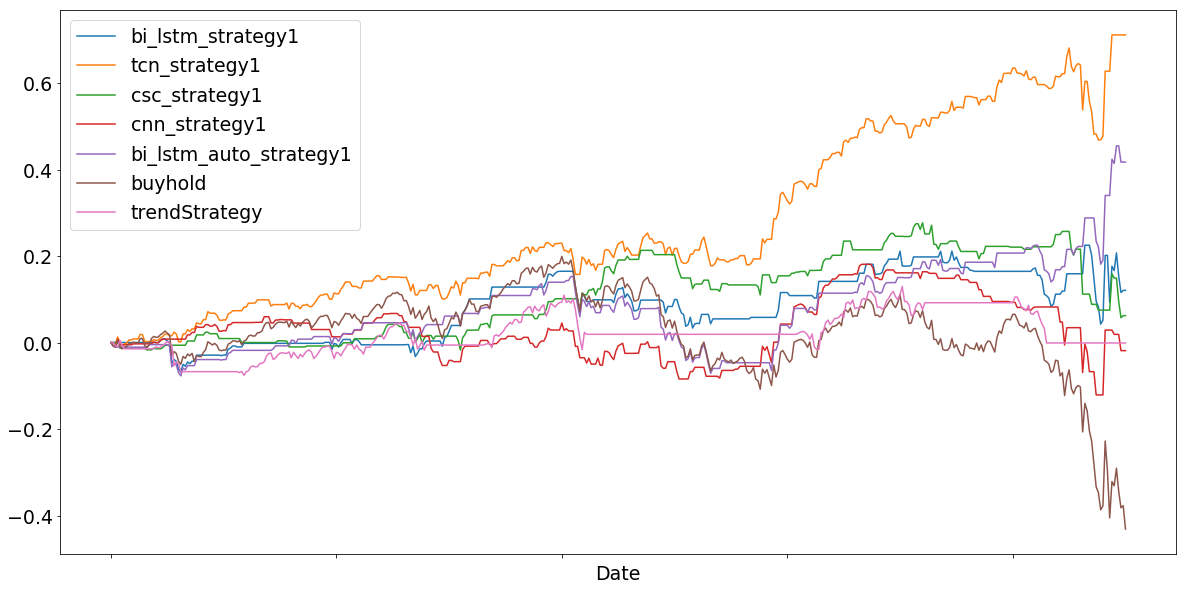

In [240]:
plotstrategies1 = strategies.plot(x="Date", y=["bi_lstm_strategy1", "tcn_strategy1", "csc_strategy1", "cnn_strategy1", "bi_lstm_auto_strategy1", "buyhold", "trendStrategy"], figsize=(20,10))

# Cumulative Returns Plot for Strategy 2

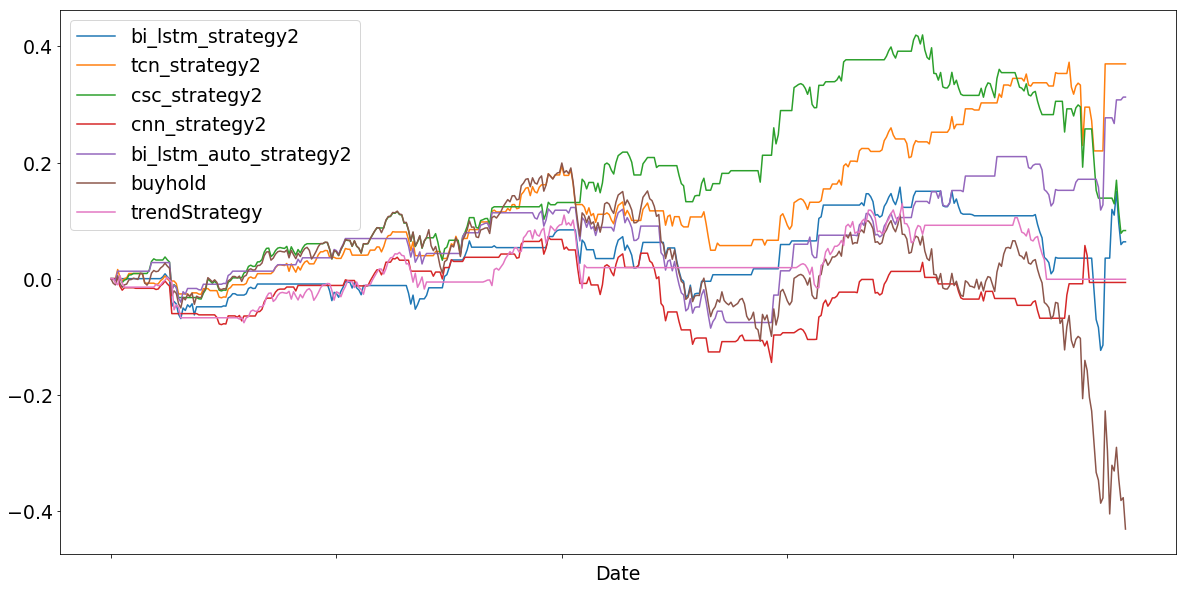

In [241]:
plotstrategies2 = strategies.plot(x="Date", y=["bi_lstm_strategy2", "tcn_strategy2", "csc_strategy2", "cnn_strategy2", "bi_lstm_auto_strategy2", "buyhold", "trendStrategy"], figsize=(20,10))

In [242]:
# Export Plot
plotstrategies1.get_figure().savefig("period1_strategy1.png")

In [243]:
# Export plot
plotstrategies2.get_figure().savefig("period1_strategy2.png")